# MACHINE LEARNING CFD CODE 
Version 1.0 by : Alexandre Ninet 
Contact : alexandre.ninet@etu.unistra.fr

## ANN Code

### Modules importation 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("Data2.txt", sep=",")

In [3]:
df


,Range,Amp,Wavelength,Frq,L2D
0,46.0,0.5,3.1,50.0,53.173396
1,46.0,0.5,3.1,50.0,53.250903
2,46.0,0.5,3.1,50.0,53.307192
3,46.0,0.5,3.1,50.0,53.184638
4,46.0,0.5,3.1,50.0,53.130043
...,...,...,...,...,...
4799899,67.0,1.0,6.2,300.0,39.930739
4799900,67.0,1.0,6.2,300.0,39.818887
4799901,67.0,1.0,6.2,300.0,40.141925
4799902,67.0,1.0,6.2,300.0,40.409509


In [4]:
### Creating the Time column
dt = 1E-5  #Simulation time step
T0 = 0.175   #first time value in the input files, fixed at 0.175 in this case

T = np.zeros((4799904))
for n in range(0, 4749904,50000):
   for i in range(0,49999):
      T[i+n] = T0+i*dt 

df['Time'] = T
df[0:100]
df[199998:250010]

,Range,Amp,Wavelength,Frq,L2D,Time
199998,46.0,0.5,6.2,50.0,53.106775,0.67498
199999,46.0,0.5,6.2,50.0,52.784920,0.00000
200000,46.0,0.5,6.2,50.0,52.738488,0.17500
200001,46.0,0.5,6.2,50.0,52.750236,0.17501
200002,46.0,0.5,6.2,50.0,52.833570,0.17502
...,...,...,...,...,...,...
250005,46.0,0.5,6.2,100.0,51.614456,0.17505
250006,46.0,0.5,6.2,100.0,51.635327,0.17506
250007,46.0,0.5,6.2,100.0,51.653560,0.17507
250008,46.0,0.5,6.2,100.0,51.783381,0.17508


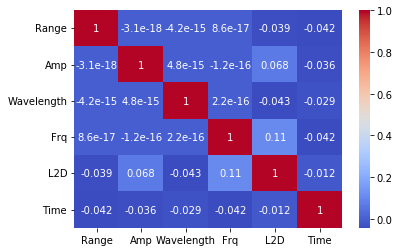

In [5]:
df_heatmap = sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')


In [6]:

X_total = df.loc[:, ['Range', 'Amp',  'Wavelength', 'Frq','Time']]
y_total = df.loc[:, ['L2D']]    

####    Important : setting the range of data we want to use at begining 

In [7]:
X_start  = X_total.loc[  0 : 49999 *1]
y_start  = y_total.loc[  0 : 49999 * 1]  #travelling wave cases are multiple of 49.999.
#Soon modified with one file per case


#### Pick target or random prediction values 

In [39]:
#### FLAGS : PREDICT TARGET TIME OR RANDOM VALUES #### 

### Choose only one : 

flag_TARGET_VALUES = 1  # 0 or 1 
flag_RANDOM_VALUES = 0  # 0 or 1  


In [56]:

#### With target time : 
if flag_TARGET_VALUES == 1 : 

	Step_test_start = 40000			#Time Step index of START of TEST SET 
	Step_test_end   = 499999			#Time step index of END of TEST SET

    
	X_test = X_start[Step_test_start:Step_test_end]
	y_test = y_start[Step_test_start:Step_test_end]

	Step_Learn_start = 0			#Time Step index of START of LEARN+VAL SET 
	Step_Learn_end = 40000          #Time Step index of END of LEARN+VAL SET 

	X = X_start[Step_Learn_start:Step_Learn_end]
	y = y_start[Step_Learn_start:Step_Learn_end]
    
	X_train, X_val, y_train, y_val = train_test_split ( X, y, test_size = 0.3, random_state = 50 )


if flag_RANDOM_VALUES == 1 :

	X, X_test, y, y_test = train_test_split (X_start, y_start, test_size = 0.2, random_state = 50)  #Change the fraction of test vs Learn+val with test_size
	X_train, X_val, y_train, y_val = train_test_split ( X, y, test_size = 0.3, random_state = 50 )


if (flag_RANDOM_VALUES==1) and (flag_TARGET_VALUES == 1):
	print(' Select only one case please')

In [57]:
y_test

,L2D
40000,55.482523
40001,55.590788
40002,55.742366
40003,55.447988
40004,55.262202
...,...
49995,53.756618
49996,53.557509
49997,53.776021
49998,53.917404


In [58]:
X_train

,Range,Amp,Wavelength,Frq,Time
10542,46.0,0.5,3.1,50.0,0.28042
23834,46.0,0.5,3.1,50.0,0.41334
32854,46.0,0.5,3.1,50.0,0.50354
37137,46.0,0.5,3.1,50.0,0.54637
2060,46.0,0.5,3.1,50.0,0.19560
...,...,...,...,...,...
34887,46.0,0.5,3.1,50.0,0.52387
32022,46.0,0.5,3.1,50.0,0.49522
22637,46.0,0.5,3.1,50.0,0.40137
38368,46.0,0.5,3.1,50.0,0.55868


### Artificial Neural Network Creation

In [59]:
###### ARTIFICIAL NEURAL NETWORK STRUCTURE #######
Predict_Model = Sequential()
Predict_Model.add(Dense(500, activation = 'sigmoid')) #Hidden Layer  
Predict_Model.add(Dense(200, activation = 'sigmoid')) #Hidden Layer
Predict_Model.add(Dense(100, activation = 'sigmoid')) #Hidden Laye
Predict_Model.add(Dense(10, activation = 'sigmoid')) #Hidden Layer
Predict_Model.add(Dense(units = 1,activation='sigmoid')) #Output Layer  
Predict_Model.compile(loss='mse'
			   , optimizer='adam')

number_epochs = 50  #Set here the number of inner iteration in the ANN (EPOCHS)




In [60]:
X_train

,Range,Amp,Wavelength,Frq,Time
10542,46.0,0.5,3.1,50.0,0.28042
23834,46.0,0.5,3.1,50.0,0.41334
32854,46.0,0.5,3.1,50.0,0.50354
37137,46.0,0.5,3.1,50.0,0.54637
2060,46.0,0.5,3.1,50.0,0.19560
...,...,...,...,...,...
34887,46.0,0.5,3.1,50.0,0.52387
32022,46.0,0.5,3.1,50.0,0.49522
22637,46.0,0.5,3.1,50.0,0.40137
38368,46.0,0.5,3.1,50.0,0.55868


In [61]:
####Creating Arrays for future plotting
Array_Split_val     = np.concatenate ((X_test,y_test), axis = 1)
df_Split = pd.DataFrame( data = Array_Split_val)
df_Split.to_csv ('Split.csv')

Array_train = np.concatenate((X, y), axis = 1 )
df_train = pd.DataFrame (data = Array_train)
df_train.to_csv('Train_time.csv')

In [62]:
scaler = MinMaxScaler()
scalery = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = scalery.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
X_val  = scaler.fit_transform(X_val)
y_test = scalery.fit_transform(y_test)
y_val  = scalery.fit_transform(y_val)

In [64]:
with tf.device('/GPU:0'):  #Forces the program to run on GPU



	#Keeping the best structure
	checkpoint_path_3 = "training_3/cp.ckpt"
	# Create a callback that saves the model's weights
	checkpoint_callback_3 = tf.keras.callbacks.ModelCheckpoint(
	checkpoint_path_3, monitor= ('val_loss'), verbose=0, save_weights_only=True,
		# Save weights, every epoch.
		save_freq='epoch',mode='auto',save_best_only=True)

		#Training the model, with train and validation sets + keeping the best iteration
	history = Predict_Model.fit(x=X_train, y=y_train, epochs= number_epochs, 
                                validation_data=(X_val, y_val), callbacks = [checkpoint_callback_3],verbose=0, 
                                batch_size= 4096)
	Predict_Model.load_weights(checkpoint_path_3)



	###Prediction part
	predictions = Predict_Model.predict(X_test)


313/313 [==============================] - 0s 639us/step


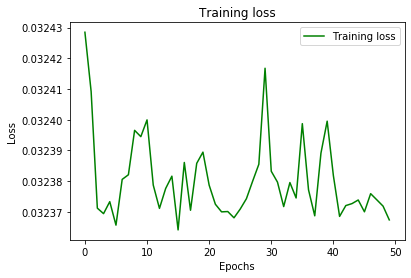

In [65]:

y_test = scalery.inverse_transform(y_test)
X_test = scaler.inverse_transform(X_test)
predictions = scalery.inverse_transform(predictions)
plt.figure('Loss')
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#DATA POST TREATEMENT FOR EXTRACTION. NEEDS ANOTHER CODE FOR THE PLOT
Array_predictions = np.concatenate ((X_test, predictions), axis = 1)
Array_True_Val     = np.concatenate ((X_test,y_test), axis = 1)
df_Predictions    = pd.DataFrame   (data = Array_predictions)
df_True_val       = pd.DataFrame   (data = Array_True_Val)

df_Predictions.to_csv ( 'Time_prediction_sigmoid.csv')
df_True_val.to_csv ('Time_true_value.csv')



In [67]:
df_Predictions

,0,1,2,3,4,5
0,46.0,0.5,3.1,50.0,0.515720,53.224598
1,46.0,0.5,3.1,50.0,0.515726,53.224598
2,46.0,0.5,3.1,50.0,0.515732,53.224598
3,46.0,0.5,3.1,50.0,0.515738,53.224598
4,46.0,0.5,3.1,50.0,0.515743,53.224598
...,...,...,...,...,...,...
9995,46.0,0.5,3.1,50.0,0.574942,53.221035
9996,46.0,0.5,3.1,50.0,0.574948,53.221035
9997,46.0,0.5,3.1,50.0,0.574954,53.221035
9998,46.0,0.5,3.1,50.0,0.574960,53.221035


In [68]:
X_train

array([[0.        , 0.        , 0.        , 0.        , 0.26355659],
       [0.        , 0.        , 0.        , 0.        , 0.5958649 ],
       [0.        , 0.        , 0.        , 0.        , 0.82137053],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.56593915],
       [0.        , 0.        , 0.        , 0.        , 0.95922398],
       [0.        , 0.        , 0.        , 0.        , 0.35000875]])

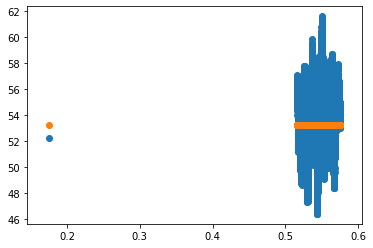

Average True :  53.91208176826426
Average Predicted :  L2D    53.315361
dtype: float64
relative error =   L2D    1.10684
dtype: float64 %
df


In [69]:

###### RESULT PLOTTING : if the Read_predict.py is not available, uncomment the following 
y_truth=y_test[:,0] 
predicted_val = df_Predictions.loc[:,[5]]
test_time     = X_test[:,4]
plt.scatter(test_time, y_truth)
plt.scatter(test_time, predicted_val)


plt.show()

print('Average True : ', y_truth.mean())
print( 'Average Predicted : ', y.mean())
print('relative error =  ', (abs(y_truth.mean()-y.mean()))/ y_truth.mean()*100,'%')
df = {'foo', 'bar'}
df = pd.DataFrame(df)
print('df')
df.to_csv('test.csv')
